# Capstone Project: Network and Host Log Analysis #
## Chalmer Lowe

The analysis of computer behavior (both the behavior of individual hosts and the behavior of traffic crossing between hosts) is fundamental to performing cyber security analysis. This assessment evaluates a portion of the data from a Los Alamos National Labs (LANL) data set comprising 90 days of host-based data collection and 90 days of network traffic. Due to the extremely large data set, we opted to limit our analysis to a subset of the total data that was collected on Day 90. We attempted to include only data from the hosts and the network that fell within the same time slot (~370 seconds out of the day). This subset of data was chosen as a means of limiting the data to a size that could be uploaded to GitHub as part of the homework submission process.

Our subset of the data is included for use with this notebook.

## Who and What on the network

Who and What: an assessment of the behavior on and between hosts on a network, based on research collected at Los Alamos National Laboratory.

In initiating this project, several questions immediately come to mind even before starting the exploratory data analysis (EDA):
* Is there a relationship between specific hosts and the number of packets (or bytes) sent?
* Is there a trend in when certain Events occur?

As the assessment progressed it was quickly discovered that the data upload limits severely impacted the amount of analysis that could be effectively performed. Because the data provided by LANL covers such a large quantity of network and host traffic and logs (estimated at 145 GB of network data and 45 GB of host data), we greatly reduced the dataset to something manageable: a total of ~150 MB of combined data from a portion of Day 90. **For emphasis:** this equates to **SIX minutes** of data.

** Data Source:** 
The original data for this project came from: [https://csr.lanl.gov/data/2017.html](https://csr.lanl.gov/data/2017.html). 

## Table of Contents

* Load Packages
* Load the Data
* Describe the Data
* Drop Unwanted Columns and Examine the Data
* Clean Corrupted Columns
* Check for Missing Observations
* Make the Column Names More Descriptive
* Plot Variables with Potential Outliers Using Boxplots
* Other Relevant Examinations and Plots
* Standardizing Variables
* Correlation Matrices
* Backup Code for Processing the Original Data

### 0. Load packages
For the project, we used the following packages

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
%matplotlib inline

<a id='load_data'></a>

### 1. Load the data

---

Our data came in two formats, a `csv` file and a `json` file. Each of these were imported into `pandas DataFrames`.

As noted in the introduction, above, there was significantly more data available than could be conveniently processed and shared as part of this project. For that reason, we did some fast and dirty preprocessing to reduce the number of records for both of the data files related to day 90. The netflow data was reduced to ~3 million records between two time stamps. The host data was reduced to ~1 million records between roughly the same time stamps.


**Host Data** The first dataset we will look at is the host data. This JSON-based file provides column headers based on the keys in the JSON. The file contains multiple JSON objects, one per line.

In [3]:
HOSTDATA = 'wls_day-90_217K'

dfhost = pd.read_json(HOSTDATA, lines=True)

**Network Data** The second dataset we will look at is the network data. This CSV-based file does not have headers built-in, for this reason, we will provide our own header names.

In [4]:
names = ['Time',
         'Duration',
         'SrcDevice',
         'DstDevice',
         'Protocol',
         'SrcPort',
         'DstPort',
         'SrcPackets',
         'DstPackets',
         'SrcBytes',
         'DstBytes',
        ]

NETDATA = 'netflow_day-90_680K'

dfnet = pd.read_csv(NETDATA, names=names)

### 2. Describe the Data

---

We started off by looking quickly at the first few rows, using `.head()` on each of our `DataFrames`.

In [5]:
dfhost.head()

,AuthenticationPackage,Destination,DomainName,EventID,FailureReason,LogHost,LogonID,LogonType,LogonTypeDescription,ParentProcessID,...,ProcessID,ProcessName,ServiceName,Source,Status,SubjectDomainName,SubjectLogonID,SubjectUserName,Time,UserName
0,None,None,Domain001,4688,None,Comp883506,0x3e7,NaN,None,0x4db8,...,0x4140,wermgr.exe,None,None,None,None,None,None,7689600,Comp883506$
1,None,None,Domain001,4688,None,Comp154941,0x3e7,NaN,None,0x3b60,...,0x36c4,Proc857443.exe,None,None,None,None,None,None,7689600,Comp154941$
2,None,None,Domain001,4688,None,Comp055724,0x3e7,NaN,None,0x3c8,...,0xbfc,taskeng.exe,None,None,None,None,None,None,7689600,Comp055724$
3,None,None,Domain001,4769,None,ActiveDirectory,None,NaN,None,None,...,None,None,ActiveDirectory$,Comp230907,0x0,None,None,None,7689600,Comp230907$
4,Kerberos,None,Domain001,4624,None,ActiveDirectory,0xf014029,3.0,Network,None,...,None,None,None,Comp230907,None,None,None,None,7689600,Comp230907$


In [6]:
dfnet.head()

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
0,7689600,0,Comp580697,Comp275646,17,Port08290,53,1,0,75,0
1,7689600,0,Comp580697,Comp275646,17,Port81132,53,1,0,75,0
2,7689600,0,Comp580697,Comp275646,17,Port21353,53,1,0,75,0
3,7689600,0,Comp258829,Comp388094,6,Port81881,Port75515,0,3,0,144
4,7689600,0,Comp819564,Comp576031,17,Port10711,514,1,0,245,0


During our initial data triage, we broke out a chunk of data from each of the two files associated with Day 90. This process was rough. To confirm that we have captured data in roughly the same time slots, we examined the time stamps to determine, start, stop and total time slice. This revealed that we have ~370 seconds of data contained within each `DataFrame`.

In [7]:
host_start = dfhost.Time.min()
host_stop = dfhost.Time.max()

print('total time slice (Hosts):', host_stop - host_start, 'seconds')
print('Start and stop times:', host_start, host_stop)
print()
net_start = dfnet.Time.min()
net_stop = dfnet.Time.max()
print('total time slice (Network):', net_stop - net_start, 'seconds')
print('Start and stop times:', net_start, net_stop)

total time slice (Hosts): 368 seconds
Start and stop times: 7689600 7689968

total time slice (Network): 371 seconds
Start and stop times: 7689600 7689971


---

From there, we used the `.dtypes()` method to look at the types of data stored in each of the `DataFrame` columns. Partly to know what we have and partly to determine whether we need to override any auto-formatting that might have occurred during data ingest. Fortunately, everything appeared to be in order.

In [8]:
dfhost.dtypes

AuthenticationPackage     object
Destination               object
DomainName                object
EventID                    int64
FailureReason             object
LogHost                   object
LogonID                   object
LogonType                float64
LogonTypeDescription      object
ParentProcessID           object
ParentProcessName         object
ProcessID                 object
ProcessName               object
ServiceName               object
Source                    object
Status                    object
SubjectDomainName         object
SubjectLogonID            object
SubjectUserName           object
Time                       int64
UserName                  object
dtype: object

In [9]:
dfnet.dtypes

Time           int64
Duration       int64
SrcDevice     object
DstDevice     object
Protocol       int64
SrcPort       object
DstPort       object
SrcPackets     int64
DstPackets     int64
SrcBytes       int64
DstBytes       int64
dtype: object

---

Similarly we used the `.info()` function look at how many rows of each type of data are included in our data sets. We noticed right away that:

* The host info has predominantly string objects with several numeric datatypes. The record count for each of the columns differs. Some of the columns have very little data, while some columns have data in each record
* The net info has predominantly numeric datatypes with several string datatypes. The record count for each of the columns is the same

In [10]:
dfhost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217000 entries, 0 to 216999
Data columns (total 21 columns):
AuthenticationPackage    66791 non-null object
Destination              6478 non-null object
DomainName               217000 non-null object
EventID                  217000 non-null int64
FailureReason            608 non-null object
LogHost                  217000 non-null object
LogonID                  191599 non-null object
LogonType                103788 non-null float64
LogonTypeDescription     103788 non-null object
ParentProcessID          64386 non-null object
ParentProcessName        64386 non-null object
ProcessID                75216 non-null object
ProcessName              75216 non-null object
ServiceName              7644 non-null object
Source                   66966 non-null object
Status                   25090 non-null object
SubjectDomainName        6333 non-null object
SubjectLogonID           6481 non-null object
SubjectUserName          6333 non-null obje

In [11]:
dfnet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680000 entries, 0 to 679999
Data columns (total 11 columns):
Time          680000 non-null int64
Duration      680000 non-null int64
SrcDevice     680000 non-null object
DstDevice     680000 non-null object
Protocol      680000 non-null int64
SrcPort       680000 non-null object
DstPort       680000 non-null object
SrcPackets    680000 non-null int64
DstPackets    680000 non-null int64
SrcBytes      680000 non-null int64
DstBytes      680000 non-null int64
dtypes: int64(7), object(4)
memory usage: 62.3+ MB


---

In addition to using `.info()`, we opted to use .describe() to get a sense for the types of data stored in the records, as well as:
* measures of central tendency and variance for numeric data
* the most frequent appearing entries for string data

We used two different arguments with `.describe()`:
* `include=np.number` to ensure that only numeric values were included
* `include=object` to ensure that only string values were included

This allowed us to take advantage of the different displays that pandas offers for numeric vs string-based values.

In [12]:
dfhost.describe(include=np.number)

,EventID,LogonType,Time
count,217000.000000,103788.000000,2.170000e+05
mean,4667.053221,3.011022,7.689781e+06
std,46.297830,0.444144,1.123760e+02
min,4624.000000,2.000000,7.689600e+06
25%,4634.000000,3.000000,7.689679e+06
50%,4648.000000,3.000000,7.689784e+06
75%,4688.000000,3.000000,7.689882e+06
max,4803.000000,9.000000,7.689968e+06


In [13]:
dfhost.describe(include=object)

,AuthenticationPackage,Destination,DomainName,FailureReason,LogHost,LogonID,LogonTypeDescription,ParentProcessID,ParentProcessName,ProcessID,ProcessName,ServiceName,Source,Status,SubjectDomainName,SubjectLogonID,SubjectUserName,UserName
count,66791,6478,217000,608,217000,191599,103788,64386,64386,75216,75216,7644,66966,25090,6333,6481,6333,217000
unique,4,97,32,4,7511,59805,7,5040,182,7916,381,512,5466,6,10,121,223,10452
top,Kerberos,Comp457365,Domain001,An Error occured during Logon.,ActiveDirectory,0x3e7,Network,0x12f4,svchost,0x2860,cmd.exe,Comp916004$,Comp916004,0x0,Domain001,0x3e7,Administrator,AppService
freq,38898,3297,208661,266,78863,61607,98856,2062,19221,3234,9239,2190,10386,24413,6094,2580,2480,34603


In [14]:
dfnet.describe(include=np.number)

,Time,Duration,Protocol,SrcPackets,DstPackets,SrcBytes,DstBytes
count,6.800000e+05,680000.000000,680000.000000,6.800000e+05,6.800000e+05,6.800000e+05,6.800000e+05
mean,7.689771e+06,286.727428,9.391049,1.892920e+02,2.647250e+02,3.424752e+04,1.901783e+05
std,1.101649e+02,2911.013155,5.081883,4.170094e+04,7.691827e+04,5.917214e+06,5.497951e+07
min,7.689600e+06,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.689672e+06,0.000000,6.000000,1.000000e+00,0.000000e+00,7.400000e+01,0.000000e+00
50%,7.689761e+06,1.000000,6.000000,4.000000e+00,1.000000e+00,2.810000e+02,6.000000e+01
75%,7.689869e+06,6.000000,17.000000,6.000000e+00,5.000000e+00,1.082000e+03,7.720000e+02
max,7.689971e+06,85892.000000,17.000000,1.709551e+07,3.618671e+07,2.579655e+09,2.766917e+10


In [15]:
dfnet.describe(include=object)

,SrcDevice,DstDevice,SrcPort,DstPort
count,680000,680000,680000,680000
unique,11692,6911,63359,10513
top,Comp030334,Comp275646,Port13777,80
freq,52527,97682,2836,106734


<a id='drop'></a>

### 2. Drop unwanted columns and examine the data

---

For various parts of my analysis, we experimented with selecting only certain columns for further analysis. We were very curious to see the relationships between the **LogonType** and the **LogonTypeDescription**, so we filtered the **dflogons** `DataFrame` to only two columns and then cleaned up the data by:
* dropping duplicates
* dropping Null values
* sorting by the LogonType

In [16]:
dflogons = dfhost[['LogonType', 'LogonTypeDescription']]
dflogons.drop_duplicates().dropna().sort_values(by='LogonType')

,LogonType,LogonTypeDescription
105,2.0,Interactive
4,3.0,Network
72,4.0,Batch
43,5.0,Service
163008,7.0,Unlock
1049,8.0,NetworkClearText
57793,9.0,NewCredentials


This led me to explore the frequency of each **LogonType**:

In [17]:
dfhost.LogonTypeDescription.value_counts()

Network             98856
Interactive          3385
Service               783
NetworkClearText      535
Batch                 214
Unlock                  8
NewCredentials          7
Name: LogonTypeDescription, dtype: int64

During the initial evaluation of the columns, we discovered that there were reasons associated with failed logons, so we displayed a frequency count of the reasons to see what types of reasons were recorded.

In [18]:
dfhost.FailureReason.value_counts()

An Error occured during Logon.                                             266
Unknown user name or bad password.                                         235
The user has not been granted the requested logon type at this machine.    103
Account currently disabled.                                                  4
Name: FailureReason, dtype: int64

Similarly, we were curious how many different entries were present in the **DomainName** column. This time we opted to sort by the items in the index to put the resultant `Series` into ASCII-betical order.

In [19]:
dfhost.DomainName.value_counts().sort_index()

Comp032135                 72
Comp125736                329
Comp146253                  1
Comp307946                  8
Comp308413                 17
Comp349403                  2
Comp350644                  8
Comp399620                  3
Comp455286                  3
Comp567356                  1
Comp585184                  8
Comp586392                  1
Comp601512                  4
Comp721756                  1
Comp735514                  5
Comp743141                  8
Comp862246                  8
Comp882724                  1
Comp896931                  1
Comp902403                  1
Comp907587                 20
Comp923957                 10
Comp966901                  1
Comp981237                  1
Domain001              208661
Domain002                1112
Domain003                  10
Domain005                  35
EnterpriseAppServer      2838
nt authority             3804
nt service                 24
workgroup                   2
Name: DomainName, dtype: int64

Based on these results, we felt like we wanted to focus some further investigation on the Domains with what appear to be "official-sounding" domain names, such as: Domain001, Domain002.

To do this, we used the `str.contains()` method to search for any entries in the **DomainName** column that contain the string `Domain`.

In [20]:
dfdomains = dfhost[dfhost['DomainName'].str.contains('Domain')]
dfdomains.DomainName.value_counts()

Domain001    208661
Domain002      1112
Domain005        35
Domain003        10
Name: DomainName, dtype: int64

Switching gears a bit... we took a look at some of the data related to the Hosts.

To evaluate a possible relationship between the number of packets sent and the number of bytes sent, we chose to drop all the unrelated columns.

In [21]:
dfpnb = dfnet.drop(columns=['Duration', 'Protocol', 'SrcPort', 'DstPort'])
dfpnb.head()

,Time,SrcDevice,DstDevice,SrcPackets,DstPackets,SrcBytes,DstBytes
0,7689600,Comp580697,Comp275646,1,0,75,0
1,7689600,Comp580697,Comp275646,1,0,75,0
2,7689600,Comp580697,Comp275646,1,0,75,0
3,7689600,Comp258829,Comp388094,0,3,0,144
4,7689600,Comp819564,Comp576031,1,0,245,0


### 3. Clean corrupted columns

---

No special cleansing of the data appeared to be necessary... by and large the data was auto-formatted as needed. 


### 4. Check for missing observations

---

We revisited the number of null records found in our datasets using an alternate methodology. By and large this data is similar to the data available in the results of the `.info()` method.

We first confirmed how many total records were in the **dfdomains** `DataFrame` by using the `len()` function.

Then we counted how many rows seemed to have missing data. Generally, what this tells me is that Host event records may vary widely and that certain details may not be required OR available in some records.

We opted to leave all rows intact for the time being (i.e. opted against dropping records with Null values).

In [22]:
print('Total number of records:', len(dfdomains))

Total number of records: 209818


In [23]:
dfdomains.isnull().sum()

AuthenticationPackage    145692
Destination              203647
DomainName                    0
EventID                       0
FailureReason            209293
LogHost                       0
LogonID                   25319
LogonType                110484
LogonTypeDescription     110484
ParentProcessID          146224
ParentProcessName        146224
ProcessID                136792
ProcessName              136792
ServiceName              202174
Source                   144731
Status                   184728
SubjectDomainName        203795
SubjectLogonID           203647
SubjectUserName          203795
Time                          0
UserName                      0
dtype: int64

Using the same technique, we see by contrast, in looking at our packets and bytes DataFrame: there are no null values in the **dfpnb** `DataFrame` and these records are much more uniform, regular and consistent.

In [24]:
dfpnb.isnull().sum()

Time          0
SrcDevice     0
DstDevice     0
SrcPackets    0
DstPackets    0
SrcBytes      0
DstBytes      0
dtype: int64

### 5. Make the column names more descriptive

---

We took a look at the column names for both our data and decided that the column names were adequate and didn't need to be changed.

In [25]:
dfdomains.columns

Index(['AuthenticationPackage', 'Destination', 'DomainName', 'EventID',
       'FailureReason', 'LogHost', 'LogonID', 'LogonType',
       'LogonTypeDescription', 'ParentProcessID', 'ParentProcessName',
       'ProcessID', 'ProcessName', 'ServiceName', 'Source', 'Status',
       'SubjectDomainName', 'SubjectLogonID', 'SubjectUserName', 'Time',
       'UserName'],
      dtype='object')

In [26]:
dfpnb.columns

Index(['Time', 'SrcDevice', 'DstDevice', 'SrcPackets', 'DstPackets',
       'SrcBytes', 'DstBytes'],
      dtype='object')

### 6. Plot variables with potential outliers using boxplots.

---
As an experiment, I applied the `.boxplot()` method from the `seaborn` package to look at one of the columns for outliers.

For the column **SrcPackets**, that we chose to evaluate via boxplot, we soon found that due to the scale and the variety of values, the results were not overwhelmingly useful for looking at the number of SrcPackets.

Upon review we felt that the other columns were likely to have similar problems. This not unexpected, based on the minimum, maximum, mean and standard deviations that we saw for the various variables.

The Default figure size was a bit small and the fonts a bit small, so we opted to increase the size a bit using `plt.figure(figsize)` and alter the fonts sizes using some default settings in `seaborn` using `sns.set_context()`.

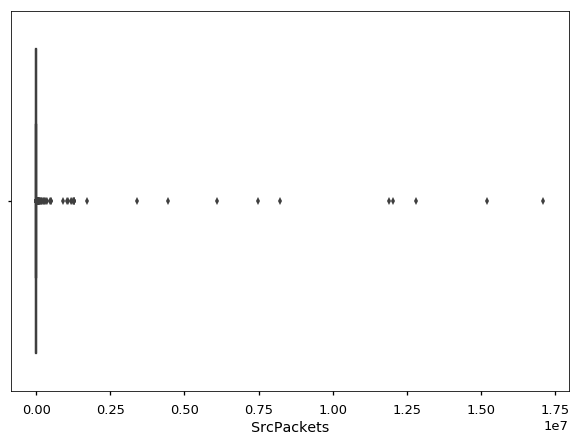

In [28]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,7))
sns.set_context('talk')
ax = sns.boxplot(x='SrcPackets', data=dfpnb)
plt.savefig('boxplot.png')

### 7. Other relevant examinations and plots 

---


In considering possible plots, a visual representation of the number of **LogonTypes** seemed like a good place to experiment, but as the results show... the disparity in values renders the plot mostly useless, since three of the columns disappear into the bottom of the graph. For comparison, we include the actual values in a frequency table.

A better visualization would probably be a log-based histogram to show the disparities in values both at the bottom end of the range AND at the high end of the range, but that suffers somewhat from potentially being visually misleading.

Value counts: 2.0     2972
3.0    95795
4.0       23
7.0        8
8.0      535
9.0        1
Name: LogonType, dtype: int64 



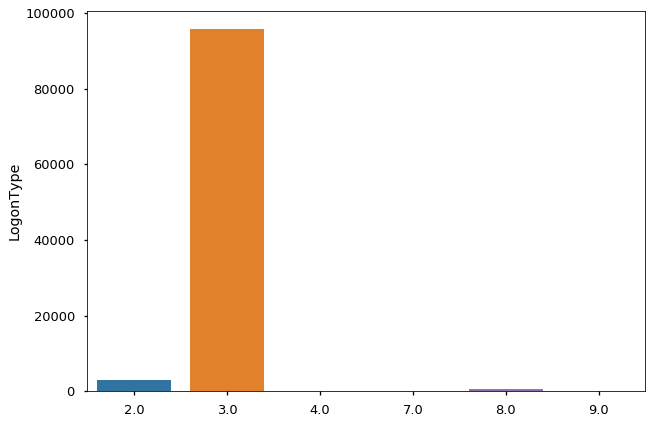

In [29]:
x = sorted(dfdomains.LogonType.dropna().unique())
y = dfdomains.LogonType.value_counts().sort_index()

print('Value counts:', y, '\n')

plt.figure(figsize=(10,7))
sns.set_context('talk')
sns.barplot(x=x, y=y, data=dfdomains, orient='v')
plt.savefig('barplot.png')


<a id='standardization'></a>

### 8. Standardizing variables

---

As an experiment, we rescaled some of the columns. In this case, we chose to rescale these columns:

* SrcPackets
* DstPackets
* SrcBytes
* DstBytes

In [30]:
X = dfpnb[['SrcPackets', 'DstPackets', 'SrcBytes', 'DstBytes']]
print(X.mean())
print(X.std())

SrcPackets       189.291954
DstPackets       264.725031
SrcBytes       34247.516318
DstBytes      190178.331859
dtype: float64
SrcPackets    4.170094e+04
DstPackets    7.691827e+04
SrcBytes      5.917214e+06
DstBytes      5.497951e+07
dtype: float64


As expected, after rescaling using the `StandardScaler()` method, the mean and standard deviation were reduced to 0 and 1, respectively.

In [31]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

print(X_standardized.mean())
print(X_standardized.std())

-1.72615190115e-19
1.0


Out of curiousity, I took a look at the results of the `scaler.fit_transform()` method to see what it looked like, but it was a `numpy` array which did not display well in Jupyter, so to simplify the display of the data, I fed the output into the `pandas DataFrame()` method and displayed the top five rows.

In [32]:
pd.DataFrame(X_standardized).head()

,0,1,2,3
0,-0.004515,-0.003442,-0.005775,-0.003459
1,-0.004515,-0.003442,-0.005775,-0.003459
2,-0.004515,-0.003442,-0.005775,-0.003459
3,-0.004539,-0.003403,-0.005788,-0.003456
4,-0.004515,-0.003442,-0.005746,-0.003459


### 9. Correlation matrices

---

Next, we took a look at some correlation matrices as an experiment to see how they work and whether there were any relationships lurking in the data.

The strongest correlations in this output are between the number of **SrcPackets** and the number of **SrcBytes** OR between the number of **DstPackets** and the number of **DstBytes**.

This relationship makes sense: one might logically conclude that the more packets you send, the more bytes will be sent. 

**NOTE**: This not a hard fast rule. Theoretically, it is possible to send small numbers of very large packets (and vice versa) and thus throw off the curve, that does not appear to be the case here.

In [33]:
dfpnb.corr()

,Time,SrcPackets,DstPackets,SrcBytes,DstBytes
Time,1.000000,0.001082,0.001079,-0.000462,0.001643
SrcPackets,0.001082,1.000000,0.741773,0.617330,0.797988
DstPackets,0.001079,0.741773,1.000000,0.273738,0.936867
SrcBytes,-0.000462,0.617330,0.273738,1.000000,0.293648
DstBytes,0.001643,0.797988,0.936867,0.293648,1.000000


The `corr()` method is useful, but seeing the correlations as a heatmap is often easier to parse than the numerical values.

Using the Seaborn `.heatmap()` to visualize the correlation did reveal an interesting relationship between the SrcBytes and the DstBytes:
* the heatmap implies that there is very little correlation between the SrcBytes and the DstBytes ... i.e. "talkative" source computers may OR may not be paired with talkative destination computers.


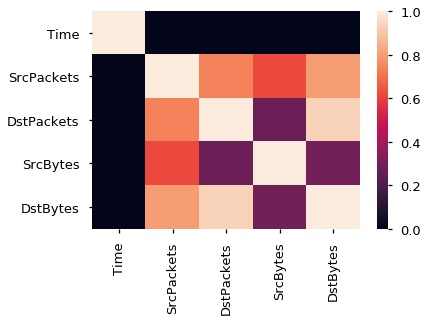

In [34]:
sns.heatmap(dfpnb.corr())

We were very curious about possible correlations between specific devices and the amount of traffic sent.

To try to identify these relationships, we needed to convert the computer names from strings to numerical values. We did this by identifying all the unique string values in the **SrcDevice** and **DstDevice** fields and pairing those with unique integers.

We started with a simple `DataFrame` with limited columns.

In [35]:
dftraffic = dfnet[['SrcDevice', 'DstDevice', 'SrcPackets', 'SrcBytes', 'DstPackets', 'DstBytes']]

We parsed down to the unique devices using the `.unique()` method. And created a dictionary that paired computer names with integers.

In [36]:
comps_src = dftraffic.SrcDevice.unique()
comps_src_dict = dict(zip(comps_src, range(len(comps_src))))

comps_dst = dftraffic.DstDevice.unique()
comps_dst_dict = dict(zip(comps_dst, range(len(comps_dst))))

We then mapped the dictionary key-value pairs against the **SrcDevice** and **DstDevice** columns, creating two new columns of unique integer identifiers for each column.

In [37]:
dftraffic['Comp_SRC'] = dftraffic.SrcDevice.map(comps_src_dict)
dftraffic['Comp_DST'] = dftraffic.DstDevice.map(comps_dst_dict)

/Users/chalmerlowe/miniconda3/envs/ds5kpy36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/chalmerlowe/miniconda3/envs/ds5kpy36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We took a look using `.head()` to confirm that our efforts were successful.

In [38]:
dftraffic.head(7)

,SrcDevice,DstDevice,SrcPackets,SrcBytes,DstPackets,DstBytes,Comp_SRC,Comp_DST
0,Comp580697,Comp275646,1,75,0,0,0,0
1,Comp580697,Comp275646,1,75,0,0,0,0
2,Comp580697,Comp275646,1,75,0,0,0,0
3,Comp258829,Comp388094,0,0,3,144,1,1
4,Comp819564,Comp576031,1,245,0,0,2,2
5,Comp518262,Comp576843,5,400,0,0,3,3
6,Comp030371,Comp576843,5,398,0,0,4,3


In looking over the heatmap of the correlation results... we see that there is no discernable relationship between the computers and the amount of traffic sent/received. It would be useful to revisit this with a complete data set over the 90 days to see if any correlations arise.

In [39]:
dftraffic.corr()

,SrcPackets,SrcBytes,DstPackets,DstBytes,Comp_SRC,Comp_DST
SrcPackets,1.000000,0.617330,0.741773,0.797988,0.007410,0.019335
SrcBytes,0.617330,1.000000,0.273738,0.293648,0.004969,0.013414
DstPackets,0.741773,0.273738,1.000000,0.936867,0.008491,0.016195
DstBytes,0.797988,0.293648,0.936867,1.000000,0.008775,0.017457
Comp_SRC,0.007410,0.004969,0.008491,0.008775,1.000000,0.075276
Comp_DST,0.019335,0.013414,0.016195,0.017457,0.075276,1.000000


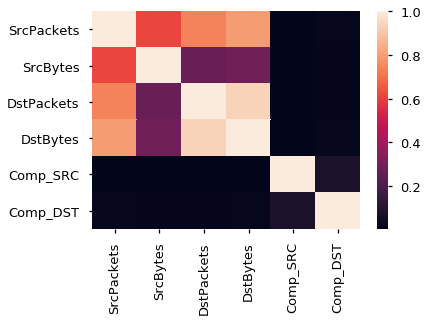

In [40]:
sns.heatmap(dftraffic.corr())

Another question that we considered was: "Is there a broad correlation between a process running and specific computers."
Based on the heatmap, the six-second data sample didn't reveal a relationship.

In [41]:
proc = dfhost.ProcessName.unique()
proc_mapping = dict(zip(proc, range(len(proc))))
dfhost['proc'] = dfhost.ProcessName.map(proc_mapping)

compname = dfhost.LogHost.unique()
compname_mapping = dict(zip(compname, range(len(compname))))
dfhost['compname'] = dfhost.LogHost.map(compname_mapping)

dfhost.head()

,AuthenticationPackage,Destination,DomainName,EventID,FailureReason,LogHost,LogonID,LogonType,LogonTypeDescription,ParentProcessID,...,ServiceName,Source,Status,SubjectDomainName,SubjectLogonID,SubjectUserName,Time,UserName,proc,compname
0,None,None,Domain001,4688,None,Comp883506,0x3e7,NaN,None,0x4db8,...,None,None,None,None,None,None,7689600,Comp883506$,0,0
1,None,None,Domain001,4688,None,Comp154941,0x3e7,NaN,None,0x3b60,...,None,None,None,None,None,None,7689600,Comp154941$,1,1
2,None,None,Domain001,4688,None,Comp055724,0x3e7,NaN,None,0x3c8,...,None,None,None,None,None,None,7689600,Comp055724$,2,2
3,None,None,Domain001,4769,None,ActiveDirectory,None,NaN,None,None,...,ActiveDirectory$,Comp230907,0x0,None,None,None,7689600,Comp230907$,3,3
4,Kerberos,None,Domain001,4624,None,ActiveDirectory,0xf014029,3.0,Network,None,...,None,Comp230907,None,None,None,None,7689600,Comp230907$,3,3


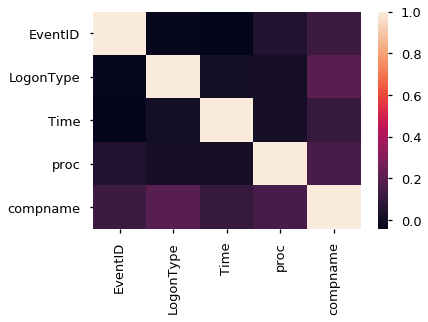

In [42]:
sns.heatmap(dfhost.corr())

We asked ourselves another question:
"Is there evidence of traffic on computer ports commonly associated with known malware?"

To answer this question, we started off by looking for a list of ports associated with malware. Such a list was found here: https://isc.sans.org/services.html. This data is published under a CC-SA license:

* (c) SANS Inst. / DShield. some rights reserved.
* Creative Commons ShareAlike License 2.5
* http://creativecommons.org/licenses/by-nc-sa/2.5/

This data is available as the file: ports.txt in our datafiles.


In looking at the port data provided by LANL, we detected several things...

The port numbers come in two categories that we refer to as:
* strictly numeric: 53, 514, 110, etc.
* labeled ports: numbers that are preceeded by the term 'Port': Port75515, Port39409, etc

Computer ports are generally used for two types of protocols: Transmission Control Protocol (TCP) and User Datagram Protocol (UDP). For each type, there are 65,536 (2^16) ports. In looking at the labeled port numbers, we noted that the numbers shown exceeded the expected upper bound of 65,536. One specific example is Port75515. The data dictionary did not explain the rationale behind this NOR did it explain why a subset of ports were strictly numeric. We presumed that the folks who created the dataset:

* had specific ports that they wanted to be readily identifiable and left those 'as is'
* masked the true values for all other ports by using coded designators (preceeded by 'Port')
* in masking the remaining values, it appears that they simply combined UDP and TCP ports and then tagged them with the unique identifiers

We did a bit of exploration to find only the ports with the string 'Port' in the name and then sorted them and examined the last ten samples present in our six-minute snippet:


In [43]:
gen_ports = dfnet.DstPort[dfnet.DstPort.str.contains('Port')].unique()
sorted(gen_ports)[-10:]

['Port99861',
 'Port99864',
 'Port99895',
 'Port99905',
 'Port99912',
 'Port99920',
 'Port99921',
 'Port99924',
 'Port99930',
 'Port99976']

Because we couldn't use these port values directly, we opted to filter them out. In doing so, we learned about the **`~` (tilda)** operator and its use in `pandas` to reverse a filter. Once we filtered our data down to just the numeric ports, we counted them using the `len()` function.

In [44]:
uniq_dst_ports = dfnet.DstPort[~ dfnet.DstPort.str.contains('Port')].unique()
len(uniq_dst_ports)


116

In [45]:
uniq_src_ports = dfnet.SrcPort[~ dfnet.SrcPort.str.contains('Port')].unique()
len(uniq_src_ports)

115

With two collections of unique ports, we then prepared a list of all the port numbers in the ports.txt file that appeared to be associated with malware. If you open the file and read it, you find that potentially malicious ports are labeled with one of three terms:

* [trojan]
* [backdoor]
* [unauthorized use]

The following snippet of code finds all lines in the file with any one of these three terms and then splits the line into fields to extract just the port number. This port number is then added to the set of malicious ports. 

All told, we had 482 ports identified by SANS as potentially related to malicious software.

In [47]:
with open('ports.txt') as fin:
    mal_ports = set()
    for line in fin:
        if '[' in line:
            for term in ['trojan', 'backdoor', 'unauthorized use']:
                if term in line:
                    fields = line.split()
                    mal_ports.add(fields[1])
    print(len(mal_ports))

482


From here, we checked for the intersection of destination ports and malicious ports AND for the intersection of source ports and malicious ports.

In [48]:
mal_dst_ports = mal_ports.intersection(uniq_dst_ports)
mal_src_ports = mal_ports.intersection(uniq_src_ports)

These sets were then applied to the the **dfnet** `DataFrame` using the `.isin()` method to detect whether content of a **\*Port** column contained any of the noted ports.

In [49]:
df_dstports = dfnet.DstPort[~ dfnet.DstPort.str.contains('Port')]
df_dstports[df_dstports.isin(mal_dst_ports)].value_counts()

514     48187
88      14845
7001     2606
123      1026
69         14
110        10
2000       10
2583        4
7000        3
5556        3
5002        2
6006        2
Name: DstPort, dtype: int64

In [50]:
df_srcports = dfnet.SrcPort[~ dfnet.SrcPort.str.contains('Port')]
df_srcports[df_srcports.isin(mal_src_ports)].value_counts()

123      557
7001     234
6006       4
2583       4
1524       3
5002       2
514        2
5556       1
7000       1
2000       1
17500      1
Name: SrcPort, dtype: int64

We opted to display this data on horizontal bar charts using the builtin capabilities of the `pandas .plot()` method for both source and destination ports.

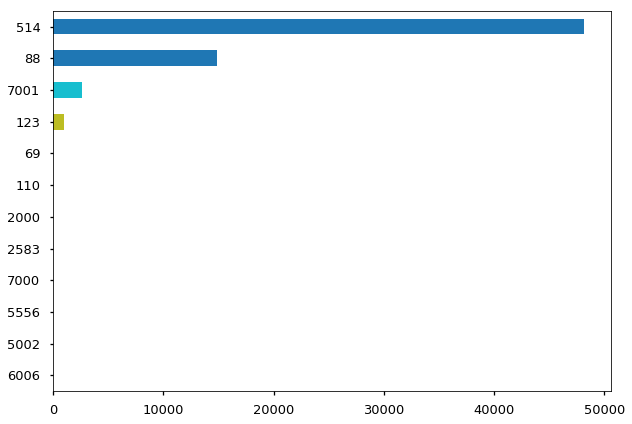

In [51]:
plt.figure(figsize=(10,7))
df_dstports[df_dstports.isin(mal_dst_ports)].value_counts(ascending=True).plot(kind='barh')
plt.savefig('enemy_of_the_state.png')

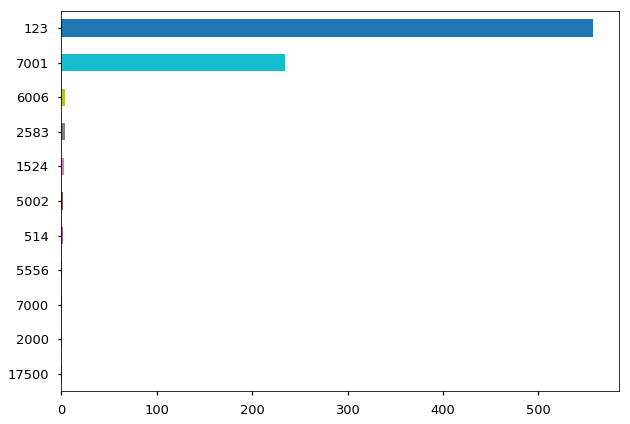

In [52]:
plt.figure(figsize=(10,7))
df_srcports[df_srcports.isin(mal_src_ports)].value_counts(ascending=True).plot(kind='barh')
plt.savefig('enemy_of_the_state_2.png')

Belatedly, we discovered that hidden away in the **Protocol** column were codes that defined whether the traffic was UDP, TCP OR an alternate protocol called Internet Control Message Protocol (ICMP). We were curious to see how this broke out in terms of numbers of messages sent using each protocol, so we did a simple value count against the **Protocol** column:

In [53]:
dfnet.Protocol.value_counts()
# 6 = tcp
# 17 = udp
# 1 = icmp

6     470085
17    209718
1        197
Name: Protocol, dtype: int64

We weren't certain we would need it OR not, but felt it might be useful to translate the numeric values to terms, so we created a mapping of each integer to a string and used the `.map()` method to create a new column labeled **ProtocolName** and displayed the result using `.head()`.

In [54]:
mapping = {6: 'TCP',
           17: 'UDP',
           1: 'ICMP',
          }

dfnet['ProtocolName'] = dfnet.Protocol.map(mapping)
dfnet.head()

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes,ProtocolName
0,7689600,0,Comp580697,Comp275646,17,Port08290,53,1,0,75,0,UDP
1,7689600,0,Comp580697,Comp275646,17,Port81132,53,1,0,75,0,UDP
2,7689600,0,Comp580697,Comp275646,17,Port21353,53,1,0,75,0,UDP
3,7689600,0,Comp258829,Comp388094,6,Port81881,Port75515,0,3,0,144,TCP
4,7689600,0,Comp819564,Comp576031,17,Port10711,514,1,0,245,0,UDP


Our next major curiousity was around how long transmissions lasted. This data is found in the **Duration** column, so we called the `.value_counts()` method. But this wasn't very effective since there were so many unique values...

In [55]:
dfnet.Duration.value_counts()

0        258648
1        226146
287       30042
288       12387
2         11594
9          9506
3          6026
301        4238
14         3932
5          3802
7          3661
15         3286
11         2819
4          2805
12         2654
10         2499
13         2419
6          1765
323        1570
36         1315
17         1274
16         1241
32         1170
31         1154
666        1001
33          962
330         947
603         921
286         887
315         879
          ...  
35202         1
11425         1
3237          1
53948         1
6461          1
7950          1
32670         1
8866          1
70276         1
32950         1
77748         1
43852         1
6309          1
6925          1
1701          1
3748          1
5287          1
5286          1
8598          1
52107         1
53951         1
51991         1
2724          1
7057          1
2963          1
24239         1
3749          1
84923         1
11937         1
19628         1
Name: Duration, Length: 

So we tackled the problem using the `bins` argument to break the data into a number of bins OR groups. The `.value_counts()` method automagically calculated the starting and enbpoints for bins... which led to some unexpected behavior.

In [56]:
dfnet.Duration.value_counts(bins=15)

(-85.893, 5726.133]       676036
(5726.133, 11452.267]       1697
(17178.4, 22904.533]         479
(28630.667, 34356.8]         365
(51535.2, 57261.333]         254
(80165.867, 85892.0]         231
(11452.267, 17178.4]         195
(40082.933, 45809.067]       193
(62987.467, 68713.6]         151
(74439.733, 80165.867]       135
(34356.8, 40082.933]         127
(68713.6, 74439.733]          98
(45809.067, 51535.2]          18
(22904.533, 28630.667]        17
(57261.333, 62987.467]         4
Name: Duration, dtype: int64

As noted above, the first bin label starts at a **negative duration!** What? So we explored the data to find all rows that had a negative duration. And there were none. The output was an empty `Series`.

In [57]:
dfnet.Duration[dfnet.Duration < 0]

Series([], Name: Duration, dtype: int64)

We tried using alternate bin counts... to no avail.

In [58]:
dfnet.Duration.value_counts(bins=6)

(-85.893, 14315.333]      677840
(14315.333, 28630.667]       584
(28630.667, 42946.0]         508
(42946.0, 57261.333]         449
(71576.667, 85892.0]         378
(57261.333, 71576.667]       241
Name: Duration, dtype: int64

After a bit of digging, we opted to use the slightly more powerful `pandas` tool `pd.cut()` to create the bins, because the `pd.cut()` method also allows you to create your own labels instead of relying upon the autogenerated labels from `.value_counts()`.

We started off by identifying the highest and lowest values for the first and last bins. And set our desired bin number. In this case we ultimately decided to go with 50.

In [59]:
lower, higher = int(dfnet.Duration.min()), int(dfnet.Duration.max())
print(lower, higher)
n_bins = 50

0 85892


We manually created edges using the upper and lower bounds, the number of bins and the step argument in the `range()` function.

In [60]:
edges = range(lower, higher, int((higher - lower)/n_bins)) 

edges

range(0, 85892, 1717)

We created a list comprehension to generate a series of strings to be used as labels for each bin...
* We needed to produce one less label than we have edges (i.e. two edges needs one label, three edges needs two labels, etc)
* We chose to calculate the edges in terms of minutes versus seconds (thus divided each edge value by 60).
* We fed each edge value into the strings using the `.format()` method

In [61]:
labels = ['({}, {}]'.format(int(edges[i]/60), int(edges[i+1]/60)) for i in range(len(edges)-1)]
labels

['(0, 28]',
 '(28, 57]',
 '(57, 85]',
 '(85, 114]',
 '(114, 143]',
 '(143, 171]',
 '(171, 200]',
 '(200, 228]',
 '(228, 257]',
 '(257, 286]',
 '(286, 314]',
 '(314, 343]',
 '(343, 372]',
 '(372, 400]',
 '(400, 429]',
 '(429, 457]',
 '(457, 486]',
 '(486, 515]',
 '(515, 543]',
 '(543, 572]',
 '(572, 600]',
 '(600, 629]',
 '(629, 658]',
 '(658, 686]',
 '(686, 715]',
 '(715, 744]',
 '(744, 772]',
 '(772, 801]',
 '(801, 829]',
 '(829, 858]',
 '(858, 887]',
 '(887, 915]',
 '(915, 944]',
 '(944, 972]',
 '(972, 1001]',
 '(1001, 1030]',
 '(1030, 1058]',
 '(1058, 1087]',
 '(1087, 1116]',
 '(1116, 1144]',
 '(1144, 1173]',
 '(1173, 1201]',
 '(1201, 1230]',
 '(1230, 1259]',
 '(1259, 1287]',
 '(1287, 1316]',
 '(1316, 1344]',
 '(1344, 1373]',
 '(1373, 1402]',
 '(1402, 1430]']

From there, we used `pd.cut()` to create the bins, which we then counted using `.value_counts()` and plotted to a horizontal bar chart.

We purposely filtered out the four lowest bins to better enable us to focus on the smaller counts at the higher end of the spectrum.

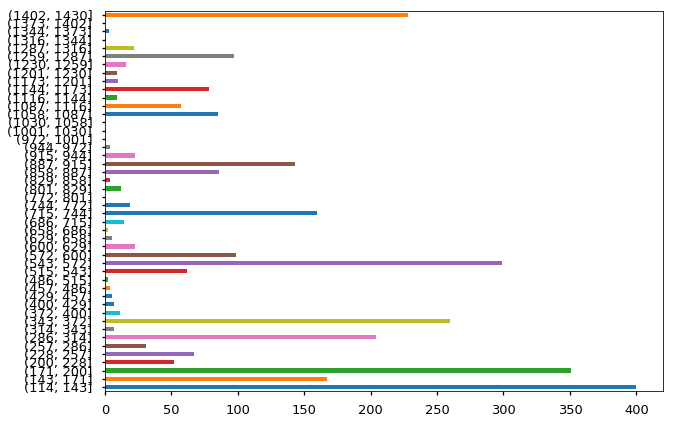

In [62]:
plt.figure(figsize=(10,7))

pd.cut(dfnet.Duration, bins=n_bins, labels=labels, include_lowest=True).value_counts(sort=False)[4:].plot('barh')
plt.savefig('rainbow_of_the_oracles.png')

Our next stage of discovery was around the types of and frequency of events as categorized by **EventID**. Of particular interest was the reasons for Logon Failure associated with **EventID** 4625.

In [63]:
dfhost.EventID.value_counts()

4688    64386
4624    52551
4634    50629
4672    17247
4776    13632
4769     7644
4648     6478
4768     3814
4625      608
4803        5
4802        3
4801        2
4800        1
Name: EventID, dtype: int64

We filtered down to just the 4625 values in the **EventID** column and looked at the `.value_counts()` for the **FailureReason**.

In [64]:
dfhost[dfhost.EventID == 4625].FailureReason.value_counts()

An Error occured during Logon.                                             266
Unknown user name or bad password.                                         235
The user has not been granted the requested logon type at this machine.    103
Account currently disabled.                                                  4
Name: FailureReason, dtype: int64

This led us to ask... is there a way to discern whether specific users are tied to particular failure types. Our first attempt at this 'worked' but it wasn't grouped nicely, as we wanted.

In [65]:
dffails = dfhost[dfhost.EventID == 4625][['FailureReason', 'UserName']]
dffails

,FailureReason,UserName
332,Unknown user name or bad password.,User260318
1067,The user has not been granted the requested lo...,AppService
1140,Unknown user name or bad password.,User234408
1164,Unknown user name or bad password.,User234408
1238,Unknown user name or bad password.,User031784
2246,Unknown user name or bad password.,User641794
2414,The user has not been granted the requested lo...,Comp289117$
3508,An Error occured during Logon.,Comp207493$
3509,An Error occured during Logon.,Comp207493$
3699,Unknown user name or bad password.,Comp881074$


So we grouped by the **FailureReason** and then performed a value count against the **UserName** column and noticed that particular user accounts had potentially inordinate numbers of failed logons (especially since we were only looking at a six minute span). This may be due some sort of automated process running. Ultimately, this did generate some fun questions:

* Who are these folks? 
* Are these services, are they automated logons?
* Do some users just suck at logging on?


In [66]:
dffails.groupby(by='FailureReason')['UserName'].value_counts()

FailureReason                                                            UserName            
Account currently disabled.                                              Comp079298$               2
                                                                         Comp800752$               1
                                                                         User760076                1
An Error occured during Logon.                                           Comp207493$             266
The user has not been granted the requested logon type at this machine.  Comp289117$              99
                                                                         AppService                2
                                                                         User494973                2
Unknown user name or bad password.                                       User515356               72
                                                                         User031784               

Our last major question was to identify users who might show up on more than one domain. To assess this, we:

* created a smaller, simpler `DataFrame`
* created a groupby using **UserName**
* created a filter, by filtering for only **UserName** groups that had more than ONE entry
* extracted just the usernames associated with the filter
* applied the usernames as a filter against the larger `DataFrame` and then displayed just those results, grouped by UserName and DomainName and showing the group size (frequency count).

In [67]:
tmp = dfhost[['UserName', 'DomainName']]
fltr = tmp.drop_duplicates().groupby('UserName').size()
usernames = fltr[fltr > 1].index
dfhost[dfhost['UserName'].isin(usernames)].groupby(['UserName', 'DomainName']).size()

UserName              DomainName         
Administrator         Comp349403                 2
                      Comp735514                 5
                      Comp981237                 1
                      Domain001               4576
AppService            Domain001              30764
                      Domain002                966
                      Domain005                 35
                      EnterpriseAppServer     2838
EnterpriseAppServer$  Domain001               6104
                      Domain003                  1
User031784            Domain001                 52
                      Domain002                 52
User032516            Comp308413                17
                      Comp585184                 8
                      Comp601512                 4
                      Comp743141                 8
                      Comp923957                10
                      Domain002                 11
User234408            Comp907587        

# Backup code for processing the original data: